In [11]:

import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from skimage.feature import hog, local_binary_pattern
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_recall_fscore_support
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
import seaborn as sns
import joblib
from collections import Counter
from sklearn.metrics import log_loss


In [12]:


# Parameters for HOG
HOG_PARAMS = {
    'orientations': 9,
    'pixels_per_cell': (8, 8),
    'cells_per_block': (2, 2),
    'block_norm': 'L2-Hys'
}

# Initialize Haar Cascade for Face Detection
face_cascade = cv2.CascadeClassifier("haarcascade_frontalface_default.xml")

In [13]:
# Data Preprocessing Functions
def preprocess_images(images):
    """
    Preprocesses a list of images by resizing and applying histogram equalization.
    """
    return [cv2.equalizeHist(cv2.resize(img, (64, 64))) for img in images]

def load_and_detect_faces(folder_path):
    """
    Loads and preprocesses images from a folder by detecting and cropping faces.
    """
    images, labels = [], []
    for label in os.listdir(folder_path):
        label_path = os.path.join(folder_path, label)
        if os.path.isdir(label_path):
            for img_file in os.listdir(label_path):
                img_path = os.path.join(label_path, img_file)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img is not None:
                    faces = face_cascade.detectMultiScale(
                        img, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30)
                    )
                    for (x, y, w, h) in faces:
                        face_region = img[y:y+h, x:x+w]
                        images.append(cv2.resize(face_region, (64, 64)))
                        labels.append(label)
    return images, labels

In [14]:
def augment_data(images, labels):
    """
    Augments the dataset by applying horizontal flips and brightness adjustments.
    """
    augmented_images, augmented_labels = [], []
    for img, label in zip(images, labels):
        augmented_images.append(img)
        augmented_labels.append(label)
        # Horizontal flip
        augmented_images.append(cv2.flip(img, 1))
        augmented_labels.append(label)
        # Brightness adjustment
        brighter = cv2.convertScaleAbs(img, alpha=1.2, beta=20)
        augmented_images.append(brighter)
        augmented_labels.append(label)
    return augmented_images, augmented_labels

In [15]:
def extract_hog_features(images):
    """
    Extracts combined LBP and HOG features from a list of images.
    """
    features = []
    for img in images:
        # Extract HOG features
        hog_features = hog(img, **HOG_PARAMS)
        # Concatenate  HOG features
        combined_features = np.hstack((hog_features))
        features.append(combined_features)
    return np.array(features)

In [16]:
# Function to plot training history
def plot_training_history(history):
    epochs = range(1, len(history['accuracy']) + 1)
    
    plt.figure(figsize=(14, 6))

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['accuracy'], label='Training Accuracy', marker='o')
    plt.plot(epochs, history['val_accuracy'], label='Validation Accuracy', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid(True)

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['loss'], label='Training Loss', marker='o')
    plt.plot(epochs, history['val_loss'], label='Validation Loss', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


In [17]:


def train_and_evaluate(train_path, test_path, dataset_name):
    print(f"Processing dataset: {dataset_name}")
    
    # ------------------------
    # 1. Load and preprocess data
    # ------------------------
    X_train, y_train = load_and_detect_faces(train_path)
    X_test, y_test = load_and_detect_faces(test_path)
    X_train = preprocess_images(X_train)
    X_test = preprocess_images(X_test)
    X_train, y_train = augment_data(X_train, y_train)
    #X_test, y_test = augment_data(X_test, y_test)

    # ------------------------
    # 2. Feature extraction
    # ------------------------
    X_train_features = extract_hog_features(X_train)
    X_test_features = extract_hog_features(X_test)

    # ------------------------
    # 3. Handle class imbalance
    # ------------------------
    print(f"Class distribution before SMOTE: {Counter(y_train)}")
    smote = SMOTE(random_state=42)
    X_train_features_balanced, y_train_balanced = smote.fit_resample(X_train_features, y_train)
    print(f"Class distribution after SMOTE: {Counter(y_train_balanced)}")

    # ------------------------
    # 4. Split into train/validation
    # ------------------------
    X_train_split, X_val, y_train_split, y_val = train_test_split(
        X_train_features_balanced, y_train_balanced, test_size=0.2, random_state=42
    )

    # ------------------------
    # 5. Cross-validation 
    #    This is just an example with gamma=0.09 for an initial check.
    # ------------------------
    print("\nPerforming cross-validation for an initial check with gamma=0.1...")
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cross_val_scores = cross_val_score(
        SVC(kernel='rbf', gamma=0.1),
        X_train_split, 
        y_train_split, 
        cv=skf, 
        scoring='accuracy'
    )
    print(f"Cross-validation accuracy scores (gamma=0.1): {cross_val_scores}")
    print(f"Mean cross-validation accuracy: {np.mean(cross_val_scores):.2f}")

    # ---------------------------------------------------------
    # 6. Hyperparameter Tuning over Gamma (Automatic Generation)
    # ---------------------------------------------------------
    # Example: log-spaced gamma range from 1e-3 to 1e1 (0.001 to 10),
    # with 5 total points: 0.001, 0.01, 0.1, 1, 10.
    # Feel free to adjust as needed (e.g., more points).
    gamma_values = np.logspace(-3, 1, 5)

    best_gamma = None
    best_val_loss = float('inf')
    
    training_losses_for_gamma = []
    val_losses_for_gamma = []
    
    training_accuracies_for_gamma = []
    val_accuracies_for_gamma = []

    for g in gamma_values:
        print(f"\nTraining SVM with gamma={g}...")
        # Train SVM with current gamma
        svm_model = SVC(kernel='rbf', gamma=g, probability=True, random_state=42)
        svm_model.fit(X_train_split, y_train_split)

        # Compute training loss
        train_probabilities = svm_model.predict_proba(X_train_split)
        current_train_loss = log_loss(y_train_split, train_probabilities)
        training_losses_for_gamma.append(current_train_loss)

        # Compute validation loss
        val_probabilities = svm_model.predict_proba(X_val)
        current_val_loss = log_loss(y_val, val_probabilities)
        val_losses_for_gamma.append(current_val_loss)

        # Compute training accuracy
        train_predictions = svm_model.predict(X_train_split)
        current_train_accuracy = accuracy_score(y_train_split, train_predictions)
        training_accuracies_for_gamma.append(current_train_accuracy)

        # Compute validation accuracy
        val_predictions = svm_model.predict(X_val)
        current_val_accuracy = accuracy_score(y_val, val_predictions)
        val_accuracies_for_gamma.append(current_val_accuracy)

        # Check if this is the best gamma so far based on validation loss
        if current_val_loss < best_val_loss:
            best_val_loss = current_val_loss
            best_gamma = g

    print(f"\nGamma values tested: {gamma_values}")
    print(f"Training Losses:   {training_losses_for_gamma}")
    print(f"Validation Losses: {val_losses_for_gamma}")
    print(f"Training Accuracies:   {training_accuracies_for_gamma}")
    print(f"Validation Accuracies: {val_accuracies_for_gamma}")
    print(f"Best gamma based on lowest validation loss: {best_gamma}")
    print(f"Best validation loss: {best_val_loss:.4f}\n")

    # Plot the loss and accuracy vs. gamma
    fig, ax1 = plt.subplots(figsize=(12, 6))

    color = 'tab:blue'
    ax1.set_xlabel('Gamma')
    ax1.set_xscale('log')
    ax1.set_ylabel('Log Loss', color=color)
    ax1.plot(gamma_values, training_losses_for_gamma, label='Training Loss', marker='o', color='blue')
    ax1.plot(gamma_values, val_losses_for_gamma, label='Validation Loss', marker='o', color='cyan')
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.legend(loc='upper left')

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:red'
    ax2.set_ylabel('Accuracy', color=color)  # we already handled the x-label with ax1
    ax2.plot(gamma_values, training_accuracies_for_gamma, label='Training Accuracy', marker='s', color='red')
    ax2.plot(gamma_values, val_accuracies_for_gamma, label='Validation Accuracy', marker='s', color='orange')
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.legend(loc='upper right')

    plt.title('Loss and Accuracy vs. Gamma')
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.grid(True, which="both", ls="--", linewidth=0.5)
    plt.show()

    # ---------------------------------------
    # 7. Final Training with the Best Gamma
    # ---------------------------------------
    print(f"Training final SVM model with best gamma={best_gamma}...")
    svm_model = SVC(kernel='rbf', gamma=best_gamma, probability=True, random_state=42)
    svm_model.fit(X_train_split, y_train_split)

    # Evaluate on training data
    train_predictions = svm_model.predict(X_train_split)
    train_probabilities = svm_model.predict_proba(X_train_split)
    train_accuracy = accuracy_score(y_train_split, train_predictions)
    train_loss = log_loss(y_train_split, train_probabilities)

    # Evaluate on validation data
    val_predictions = svm_model.predict(X_val)
    val_probabilities = svm_model.predict_proba(X_val)
    val_accuracy = accuracy_score(y_val, val_predictions)
    val_loss = log_loss(y_val, val_probabilities)

    # Store in a history dict (for plotting with your existing function)
    history = {
        'accuracy': [train_accuracy],
        'val_accuracy': [val_accuracy],
        'loss': [train_loss],
        'val_loss': [val_loss]
    }

    # Plot final training vs. validation metrics
    plot_training_history(history)

    # ------------------------
    # 8. Evaluate on the Test Set
    # ------------------------
    y_pred = svm_model.predict(X_test_features)
    accuracy = accuracy_score(y_test, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')
    report = classification_report(y_test, y_pred)

    # Print overall test metrics
    print(f"Test Accuracy:  {accuracy:.4f}")
    print(f"Test Precision: {precision:.4f}")
    print(f"Test Recall:    {recall:.4f}")
    print(f"Test F1-Score:  {f1:.4f}")
    print("\nClassification Report:\n", report)

    # Confusion Matrix
    plt.figure(figsize=(8, 8))
    conf_matrix = confusion_matrix(y_test, y_pred)
    sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt='g')
    plt.title(f"Confusion Matrix: {dataset_name}")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # Visualize some classified faces
    show_classification_examples(X_test, y_test, y_pred, n=3)

    # Return the final results
    return accuracy, precision, recall, f1, report, svm_model


In [18]:
# ------------------------
# Function to plot training history
# ------------------------
def plot_training_history(history):
    epochs = range(1, len(history['accuracy']) + 1)
    
    plt.figure(figsize=(14, 6))

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['accuracy'], label='Training Accuracy', marker='o')
    plt.plot(epochs, history['val_accuracy'], label='Validation Accuracy', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid(True)

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['loss'], label='Training Loss', marker='o')
    plt.plot(epochs, history['val_loss'], label='Validation Loss', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

In [19]:
def show_classification_examples(images, true_labels, predicted_labels, n=3):
    """
    Displays examples of faces classified with three different emotions.
    """
    emotions_to_display = ['happy', 'sad', 'angry', 'Angry', 'Sad', 'Happy']  # Example emotion labels
    indices_to_display = []

    for emotion in emotions_to_display:
        emotion_indices = [i for i, label in enumerate(predicted_labels) if label == emotion]
        indices_to_display.extend(emotion_indices[:n])

    plt.figure(figsize=(15, 10))
    for i, idx in enumerate(indices_to_display[:3 * n]):
        plt.subplot(n, 3, i + 1)
        plt.imshow(images[idx], cmap='gray')
        plt.title(f"True: {true_labels[idx]}, Pred: {predicted_labels[idx]}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

Processing dataset: CK_dataset
Class distribution before SMOTE: Counter({'neutral': 258, 'surprise': 246, 'happy': 225, 'sadness': 123, 'anger': 120, 'fear': 48})
Class distribution after SMOTE: Counter({'happy': 258, 'fear': 258, 'surprise': 258, 'sadness': 258, 'neutral': 258, 'anger': 258})

Performing cross-validation for an initial check with gamma=0.1...
Cross-validation accuracy scores (gamma=0.1): [0.89516129 0.89919355 0.87096774 0.89878543 0.90283401]
Mean cross-validation accuracy: 0.89

Training SVM with gamma=0.001...

Training SVM with gamma=0.01...

Training SVM with gamma=0.1...

Training SVM with gamma=1.0...

Training SVM with gamma=10.0...

Gamma values tested: [1.e-03 1.e-02 1.e-01 1.e+00 1.e+01]
Training Losses:   [1.1839485881400336, 0.4298140010694996, 0.047778968213528, 2.844278067389039e-05, 0.14168351749230004]
Validation Losses: [1.1938143424186038, 0.6488639967739552, 0.29784283768835035, 0.8280287613588216, 1.4770466214158928]
Training Accuracies:   [0.3618

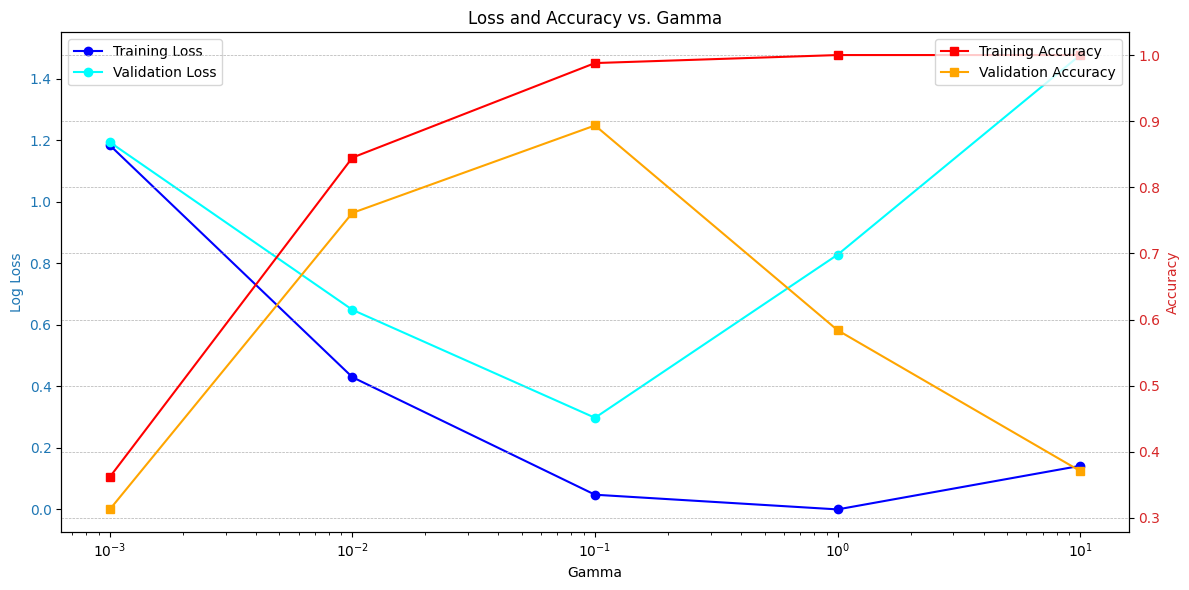

Training final SVM model with best gamma=0.1...


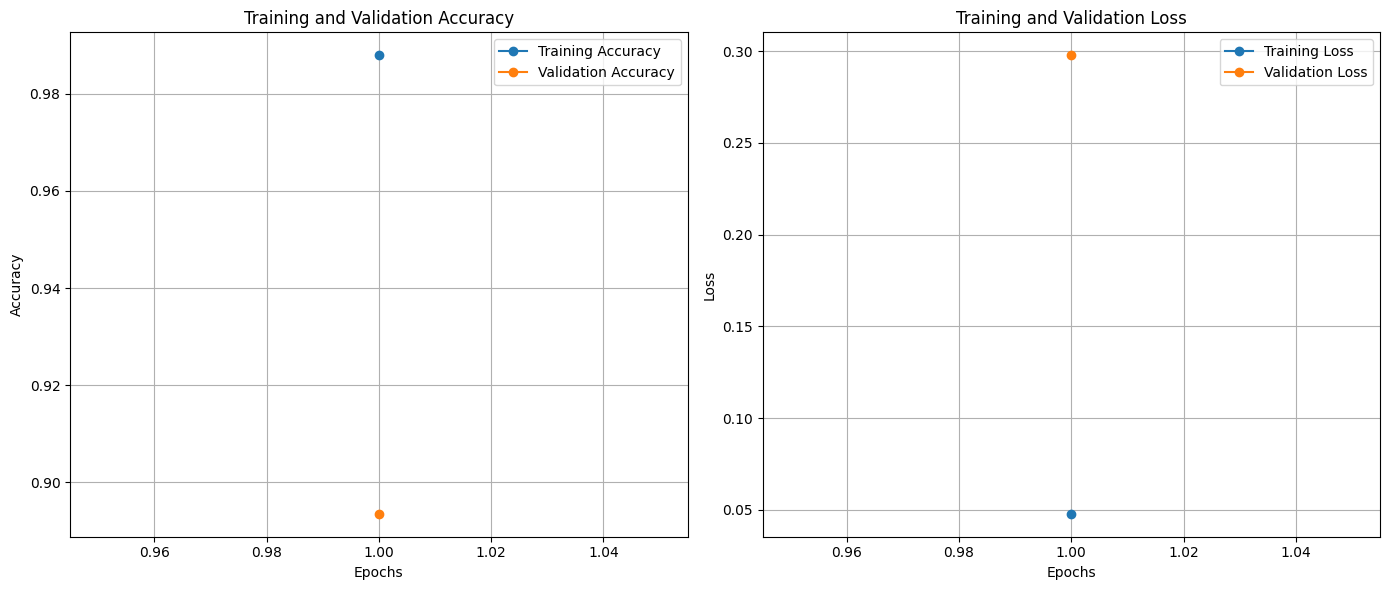

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

Test Accuracy:  0.6294
Test Precision: 0.6644
Test Recall:    0.6294
Test F1-Score:  0.6184

Classification Report:
               precision    recall  f1-score   support

       anger       0.88      0.39      0.54        18
        fear       0.00      0.00      0.00         7
       happy       0.90      0.87      0.88        30
     neutral       0.42      0.78      0.55        36
     sadness       0.42      0.29      0.34        17
    surprise       0.86      0.69      0.76        35

    accuracy                           0.63       143
   macro avg       0.58      0.50      0.51       143
weighted avg       0.66      0.63      0.62       143



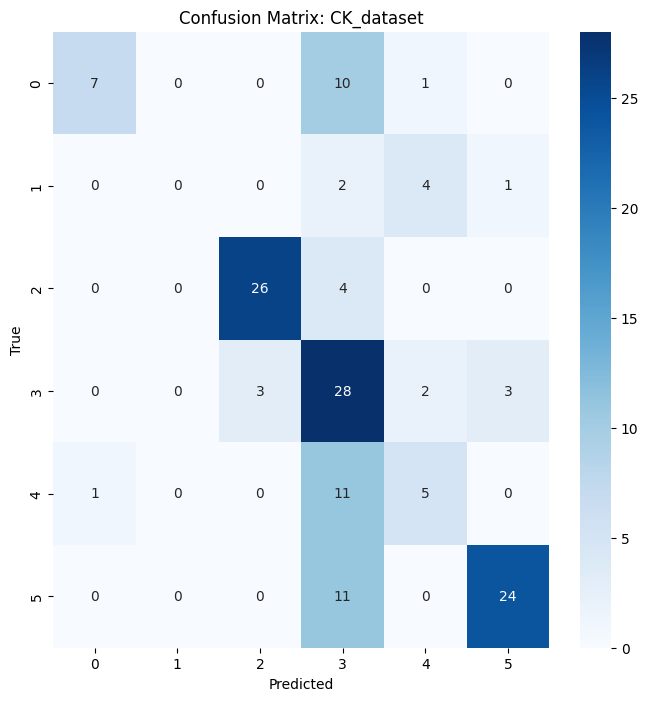

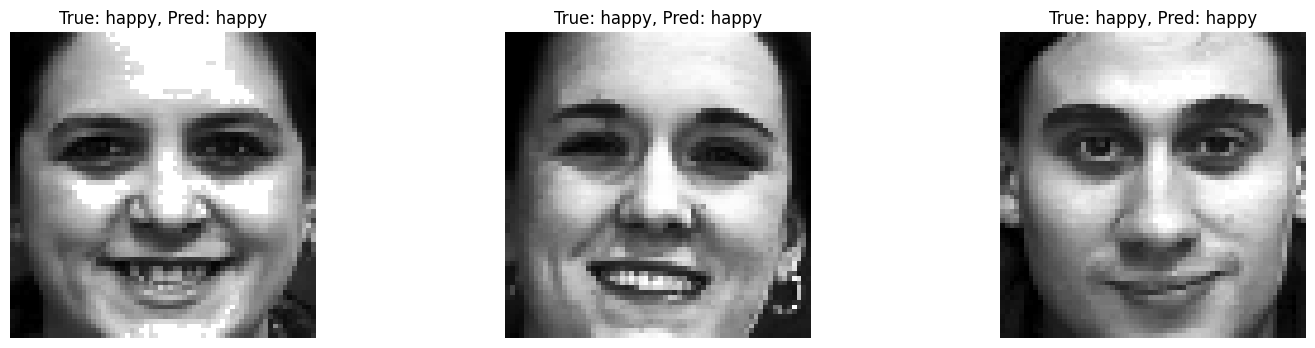

Processing dataset: JAFFE
Class distribution before SMOTE: Counter({'Happy': 66, 'Sad': 66, 'Fear': 66, 'Surprise': 63, 'Neutral': 63, 'Angry': 60})
Class distribution after SMOTE: Counter({'Happy': 66, 'Sad': 66, 'Fear': 66, 'Surprise': 66, 'Neutral': 66, 'Angry': 66})

Performing cross-validation for an initial check with gamma=0.1...
Cross-validation accuracy scores (gamma=0.1): [0.890625   0.80952381 0.82539683 0.9047619  0.80952381]
Mean cross-validation accuracy: 0.85

Training SVM with gamma=0.001...

Training SVM with gamma=0.01...

Training SVM with gamma=0.1...

Training SVM with gamma=1.0...

Training SVM with gamma=10.0...

Gamma values tested: [1.e-03 1.e-02 1.e-01 1.e+00 1.e+01]
Training Losses:   [1.3941960337401855, 0.6251855636035993, 0.03539438005230615, 1.2493443756982614, 4.263537167780808]
Validation Losses: [1.37393600629794, 0.7559354175831138, 0.2869641309763885, 1.6613976657414458, 1.811536446196405]
Training Accuracies:   [0.18037974683544303, 0.70886075949367

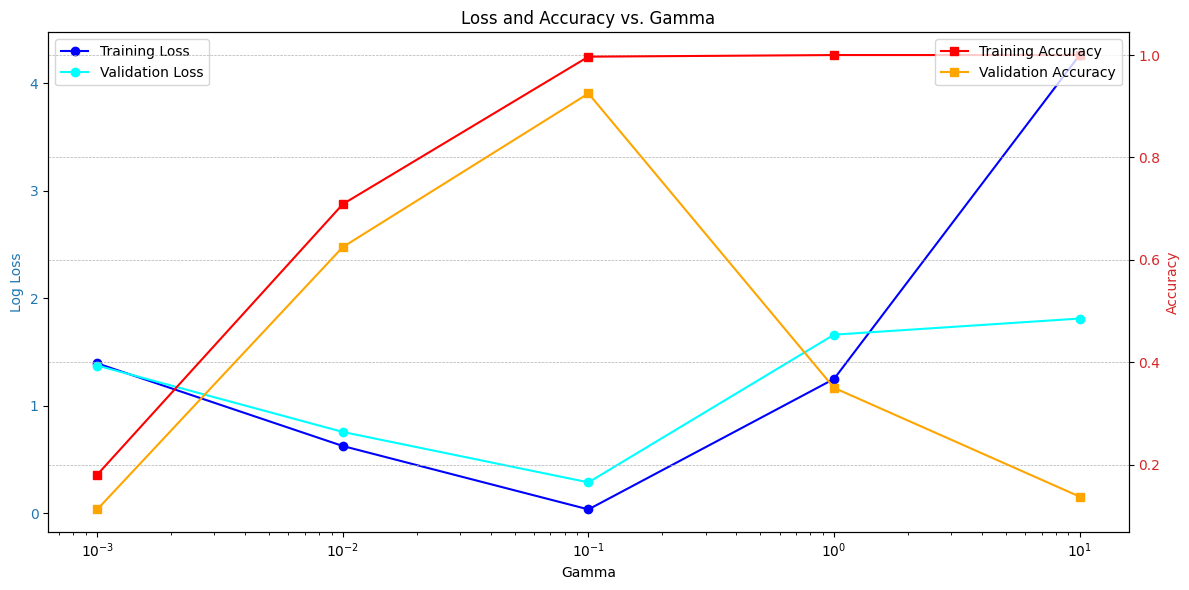

Training final SVM model with best gamma=0.1...


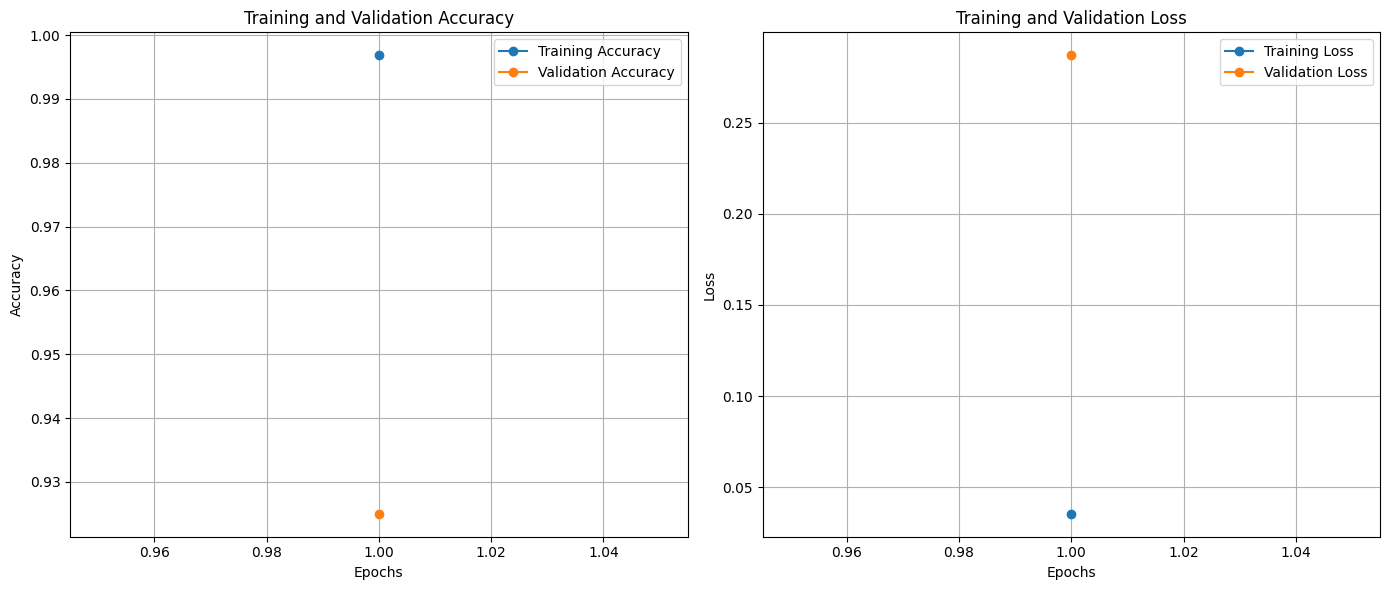

Test Accuracy:  0.8000
Test Precision: 0.8623
Test Recall:    0.8000
Test F1-Score:  0.8038

Classification Report:
               precision    recall  f1-score   support

       Angry       1.00      0.67      0.80         9
        Fear       0.59      1.00      0.74        10
       Happy       1.00      0.67      0.80         9
     Neutral       0.89      0.89      0.89         9
         Sad       0.73      0.89      0.80         9
    Surprise       1.00      0.67      0.80         9

    accuracy                           0.80        55
   macro avg       0.87      0.80      0.80        55
weighted avg       0.86      0.80      0.80        55



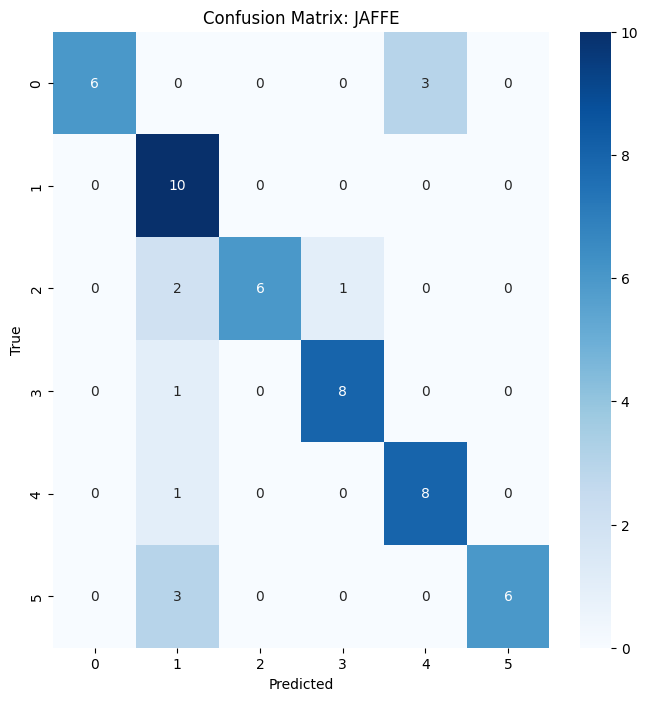

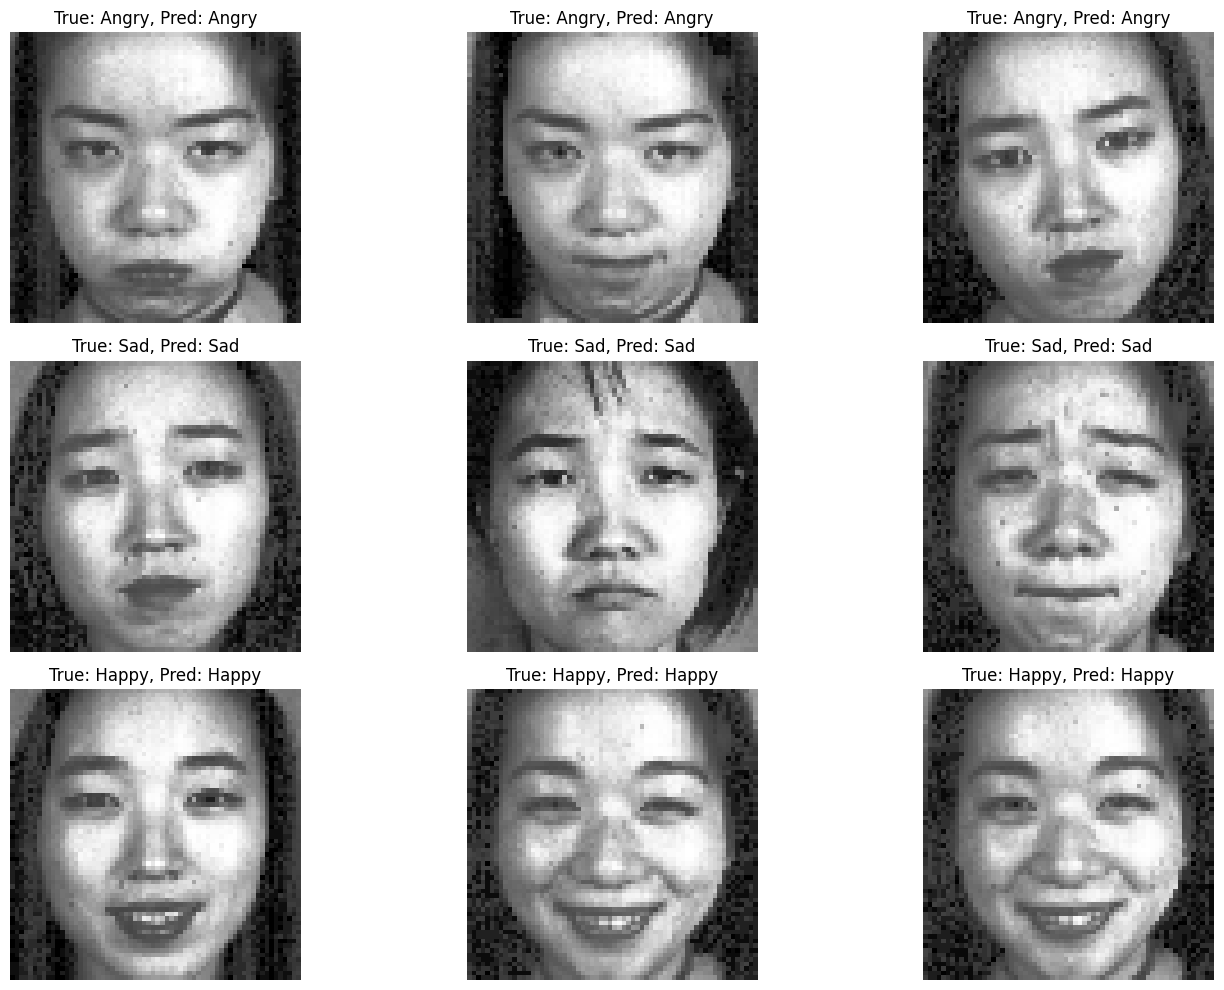

In [20]:
# Paths for both datasets
datasets = {
    "CK_dataset": ("CK_dataset/train", "CK_dataset/test"),
    "JAFFE": ("JAFFE-[70,30]/train", "JAFFE-[70,30]/test")
}

# Evaluate on each dataset
results = {}
models = {}
for dataset_name, (train_path, test_path) in datasets.items():
    accuracy, precision, recall, f1, report, model = train_and_evaluate(train_path, test_path, dataset_name)
    results[dataset_name] = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1,
        "Classification Report": report
    }
    models[dataset_name] = model

# Save results to a file
with open("evaluation_results.txt", "w") as f:
    for dataset, metrics in results.items():
        f.write(f"Dataset: {dataset}\n")
        f.write(f"Accuracy: {metrics['Accuracy'] * 100:.2f}%\n")
        f.write(f"Precision: {metrics['Precision']:.2f}\n")
        f.write(f"Recall: {metrics['Recall']:.2f}\n")
        f.write(f"F1-Score: {metrics['F1-Score']:.2f}\n")
        f.write(f"Classification Report:\n{metrics['Classification Report']}\n\n")